In [74]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))

from src.utils.option_metrics import OptionMetricsFetcher
from src.engine.rbergomi import RBergomiEngine
from src.engine.calibrator import RBergomiCalibrator
from src.pricing.pricer import MonteCarloPricer

def extract_xi_variance_swap(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    df = df_slice.sort_values('strike').copy()
    F = S0 * np.exp(r * T)
    
    df['price'] = (df['best_bid'] + df['best_offer']) / 2
    
    
    term_list = []
    strikes = df['strike'].values
    prices = df['mid_price'].values
    
    for i in range(1, len(strikes)-1):
        dK = (strikes[i+1] - strikes[i-1]) / 2.0
        K = strikes[i]
        Q = prices[i]
        
        contribution = (dK / (K**2)) * np.exp(r*T) * Q
        term_list.append(contribution)
        
    sigma_squared = (2 / T) * sum(term_list)
    
    return sigma_squared

def extract_xi_atm(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    F = S0 * np.exp(r * T)
    
    df_slice = df_slice.copy()
    df_slice['dist_to_forward'] = abs(df_slice['strike'] - F)
    
    atm_option = df_slice.sort_values('dist_to_forward').iloc[0]
    
    sigma_atm = atm_option['impl_volatility']
    
    if pd.isna(sigma_atm) or sigma_atm <= 0:
        raise ValueError(f"Volatilité ATM invalide pour Strike={atm_option['strike']}: {sigma_atm}")

    xi_estime = sigma_atm ** 2
    
    info = {"xi_estime" : xi_estime,
        'forward_price': F,
        'atm_strike_found': atm_option['strike'],
        'atm_vol': sigma_atm,
        'distance_rel': atm_option['dist_to_forward'] / F, 
        'cp_flag': atm_option['cp_flag']
    }
    
    return xi_estime, info

om = OptionMetricsFetcher()

TICKER = 'SPX'
START = '2025-01-01'
END = '2025-01-31'

df_result = om.fetch_data(TICKER, START, END)

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [137]:
from src.utils.cleaning import clean_and_filter_options, get_calibration_snapshot
df_clean = clean_and_filter_options(df_result)

calib_slice, T_exact, S0, r = get_calibration_snapshot(df_clean, '2025-01-03', 259/365)

print(f"\n--- (S0={S0}, T={T_exact:.4f}) ---")
calib_slice.sort_values("moneyness", ascending=False, inplace=True)
calib_slice


--- (S0=5942.47, T=0.7096) ---


,date,exdate,stock_price,strike,cp_flag,moneyness,mid_price,best_bid,best_offer,risk_free_rate,impl_volatility,delta,gamma,vega,theta,days_to_maturity,years_to_maturity,volume,open_interest
30398,2025-01-03,2025-09-19,5942.47,4625.0,P,1.284858,49.05,48.8,49.3,0.048276,0.252601,-0.078657,0.000116,731.8876,-111.0606,259,0.709589,46.0,695.0
30401,2025-01-03,2025-09-19,5942.47,4700.0,P,1.264355,53.3,53.1,53.5,0.048276,0.246738,-0.08609,0.000127,783.3283,-115.1588,259,0.709589,21.0,18251.0
30403,2025-01-03,2025-09-19,5942.47,4750.0,P,1.251046,56.35,56.1,56.6,0.048276,0.242857,-0.091441,0.000135,819.2604,-117.8534,259,0.709589,408.0,7433.0
30405,2025-01-03,2025-09-19,5942.47,4800.0,P,1.238015,59.6,59.3,59.9,0.048276,0.239011,-0.097144,0.000144,856.5994,-120.5229,259,0.709589,221.0,5506.0
30406,2025-01-03,2025-09-19,5942.47,4825.0,P,1.2316,61.4,61.1,61.7,0.048276,0.23721,-0.100222,0.000148,876.3539,-121.9807,259,0.709589,193.0,1006.0
30412,2025-01-03,2025-09-19,5942.47,4975.0,P,1.194466,73.05,72.7,73.4,0.048276,0.226099,-0.120478,0.000177,999.8824,-129.8197,259,0.709589,45.0,2393.0
30413,2025-01-03,2025-09-19,5942.47,5000.0,P,1.188494,75.25,74.9,75.6,0.048276,0.224301,-0.12427,0.000183,1021.828,-131.0884,259,0.709589,202.0,18755.0
30414,2025-01-03,2025-09-19,5942.47,5025.0,P,1.182581,77.55,77.2,77.9,0.048276,0.222538,-0.128206,0.000188,1044.24,-132.3622,259,0.709589,10.0,1210.0
30416,2025-01-03,2025-09-19,5942.47,5075.0,P,1.17093,82.3,81.9,82.7,0.048276,0.218955,-0.136392,0.000199,1089.666,-134.7168,259,0.709589,17.0,219.0
30419,2025-01-03,2025-09-19,5942.47,5150.0,P,1.153878,90.0,89.6,90.4,0.048276,0.213601,-0.149649,0.000218,1160.005,-137.9228,259,0.709589,88.0,2084.0


In [138]:
np.sort(df_clean[df_clean["date"] == '2025-01-03']["days_to_maturity"].unique())

array([  10,   11,   12,   13,   14,   18,   19,   20,   21,   24,   25,
         26,   27,   28,   31,   32,   33,   34,   35,   38,   40,   42,
         49,   52,   56,   63,   77,   87,  104,  117,  133,  147,  168,
        178,  196,  224,  259,  270,  287,  322,  350,  362,  378,  441,
        531,  714, 1078, 1442, 1813])

In [155]:
# xi_estime, info = extract_xi_atm(calib_slice)
# info
xi_estime = extract_xi_variance_swap(calib_slice) + 0.002
xi_estime

np.float64(0.02872435917303718)

In [156]:
engine = RBergomiEngine(
    S_0=S0,
    T=T_exact,
    N=500,
    r=r,
    xi_0=xi_estime,
    H=0.07,
    rho=-0.7,
    eta=1.9  
)

pricer = MonteCarloPricer(engine)

In [157]:
calib_data_dict = {
    'market_strike': calib_slice['strike'],
    'ivs': calib_slice['impl_volatility'],
    'option_type': calib_slice['cp_flag']
}

turbo_calibrator = RBergomiCalibrator(engine, pricer, calib_data_dict, n_paths=2000)

initial_guess = [-0.8, 2.2]

print("Starting Calibration with L-BFGS-B...")
opt_params = turbo_calibrator.calibrate(initial_guess=initial_guess)

if opt_params is not None:
    rho_opt, eta_opt = opt_params
    print(f"\n RESULTS :")
    print(f"Rho (Skew) : {rho_opt:.4f}")
    print(f"Eta (Vol-of-Vol) : {eta_opt:.4f}")
    print(f"Xi (Fixed) : {xi_estime:.6f}")
else:
    print("Calibration Failed.")

Calibrator initialized with 56 options (17 Calls, 39 Puts).
Starting Calibration with L-BFGS-B...
Starting calibration (n_paths=2000)...
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00886
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00886
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00886
 >> Step: rho=-0.8218 | eta=2.1969 | RMSE=0.00842
 >> Step: rho=-0.8218 | eta=2.1969 | RMSE=0.00842
 >> Step: rho=-0.8218 | eta=2.1969 | RMSE=0.00842
 >> Step: rho=-0.9352 | eta=2.1497 | RMSE=0.00791
 >> Step: rho=-0.9352 | eta=2.1497 | RMSE=0.00791
 >> Step: rho=-0.9352 | eta=2.1497 | RMSE=0.00791
 >> Step: rho=-0.8856 | eta=2.1582 | RMSE=0.00759
 >> Step: rho=-0.8856 | eta=2.1582 | RMSE=0.00759
 >> Step: rho=-0.8856 | eta=2.1582 | RMSE=0.00759
 >> Step: rho=-0.8923 | eta=2.1461 | RMSE=0.00755
 >> Step: rho=-0.8923 | eta=2.1461 | RMSE=0.00755
 >> Step: rho=-0.8923 | eta=2.1461 | RMSE=0.00755
 >> Step: rho=-0.9025 | eta=2.0987 | RMSE=0.00745
 >> Step: rho=-0.9025 | eta=2.0987 | RMSE=0.00745
 >> Step: rho

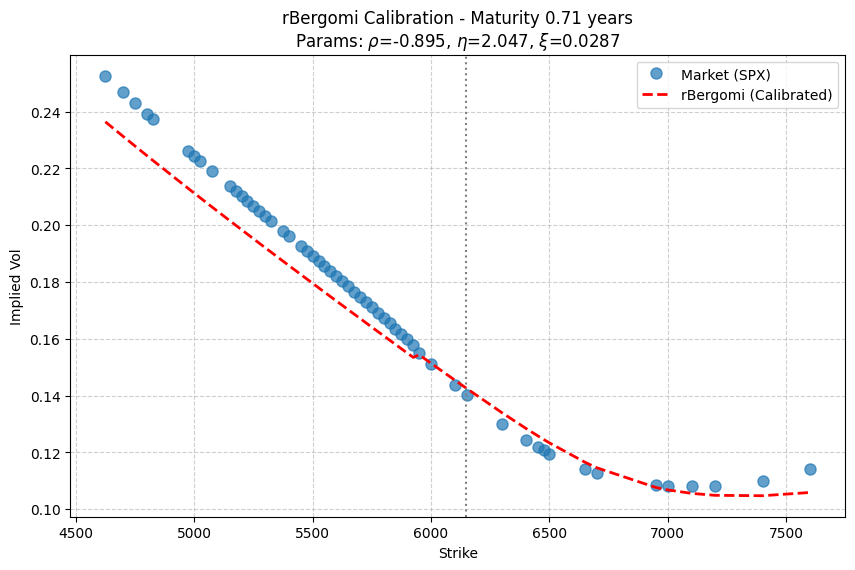

In [158]:
final_ivs_model = []

strikes = calib_slice['strike'].values
types = calib_slice['cp_flag'].values
mkt_ivs = calib_slice['impl_volatility'].values

model_ivs_res = np.zeros_like(mkt_ivs)

mask_c = (types == 'call') | (types == 'C')
if np.any(mask_c):
    _, _, ivs_c = pricer.price_european_option_turbo(
        K=strikes[mask_c], n_paths=5000, option_type='call', return_iv=True 
    )
    model_ivs_res[mask_c] = ivs_c

mask_p = (types == 'put') | (types == 'P')
if np.any(mask_p):
    _, _, ivs_p = pricer.price_european_option_turbo(
        K=strikes[mask_p], n_paths=5000, option_type='put', return_iv=True
    )
    model_ivs_res[mask_p] = ivs_p

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(strikes, mkt_ivs, 'o', label='Market (SPX)', markersize=8, alpha=0.7)
plt.plot(strikes, model_ivs_res, '--', label=f'rBergomi (Calibrated)', linewidth=2, color='red')

plt.title(f"rBergomi Calibration - Maturity {T_exact:.2f} years\n"
          f"Params: $\\rho$={rho_opt:.3f}, $\\eta$={eta_opt:.3f}, $\\xi$={xi_estime:.4f}")
plt.xlabel("Strike")
plt.ylabel("Implied Vol")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvline(x=S0 * np.exp(r * T_exact), color='gray', linestyle=':', label='Forward Price')

plt.show()
